In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from scipy import stats
from sklearn.metrics import r2_score

from func2graph import data, models, tools, baselines

In [3]:
neuron_num = 200   #####################
tau = 1   ##################### !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

init_scale = 0.2
weight_scale = 0.2
error_scale = 1

total_time = 30000
data_random_seed=42 ######################
weight_type="cell_type"

window_size = 200
predict_window_size = 1
batch_size = 32
task_type = 'prediction'
data_type = 'wuwei'
spatial_partial_measurement = 200

data_result = data.generate_simulation_data(
    neuron_num=neuron_num,
    tau=tau,
    weight_scale=weight_scale,
    init_scale=init_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
    window_size=window_size,
    batch_size=batch_size,
    task_type=task_type,
    predict_window_size=predict_window_size,
    data_type=data_type,
    spatial_partial_measurement=spatial_partial_measurement,
)

# cell_type_ids records the cell type of each neuron
trainloader, validloader, weight_matrix, b, cell_type_ids, cell_type_order, cell_type_count = data_result
weight_matrix = weight_matrix.detach().numpy()

max_abs = np.max(np.abs(weight_matrix))
vmin_NN = -max_abs
vmax_NN = max_abs

torch.Size([200, 30000])
val_data.shape:  torch.Size([5801, 200, 200])
tensor([[ 1.0233,  0.5935, -1.2659,  ...,  0.0241, -2.3161,  0.8213],
        [-0.8797,  1.4535, -0.5008,  ..., -0.1547,  0.5489,  0.8281],
        [ 2.2548,  1.6819, -3.1962,  ...,  0.9104,  0.0334,  2.3799],
        ...,
        [-0.0172,  0.1886,  0.5186,  ...,  1.7620,  0.1062,  0.0391],
        [-2.3137,  1.9204,  1.2398,  ...,  1.0783, -0.8347,  0.5856],
        [ 0.9877,  0.6830,  1.1217,  ...,  2.0125,  0.0441,  1.0597]])


In [5]:
# loop through trainloader

all_windows = []

for batch in enumerate(trainloader):
    all_windows.append(batch[1][0])
    
all_windows = np.concatenate(all_windows, axis=0)
print(all_windows.shape)

(23801, 200, 199)


In [6]:
result = np.zeros((neuron_num, 24000))
for i in range(23801):
    result[:, i:i+199] = all_windows[i, :, :]

print(result.shape)

(200, 24000)


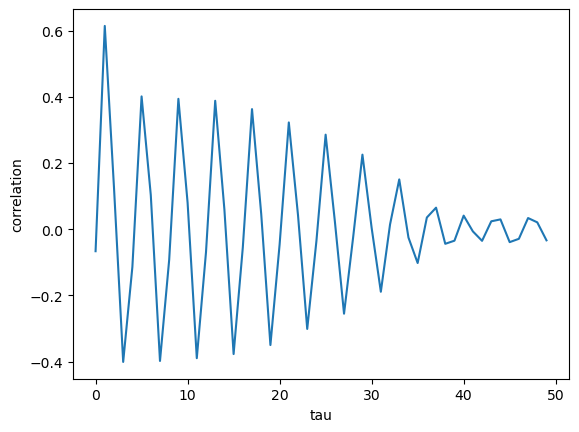

In [20]:
taus = range(0, 50)
corrs = []
for tau in taus:
    cross_corr = np.zeros((neuron_num, neuron_num))
    for i in range(neuron_num):
        for j in range(neuron_num):
            postsynaptic = result[i, tau:]
            if tau == 0:
                presynaptic = result[j, :]
            else:
                presynaptic = result[j, :-tau]
            cross_corr[i, j] = np.corrcoef(presynaptic, postsynaptic)[0, 1]
    # corrs.append(np.abs(stats.pearsonr(weight_matrix.flatten(), cross_corr.flatten())[0]))
    corrs.append(stats.pearsonr(weight_matrix.flatten(), cross_corr.flatten())[0])

plt.plot(taus, corrs)
plt.xlabel("tau")
plt.ylabel("cross-correlation")
# plt.xticks(taus)
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0: 100%|██████████| 182/182 [00:01<00:00, 146.47it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  2578           	|  2.9651         	

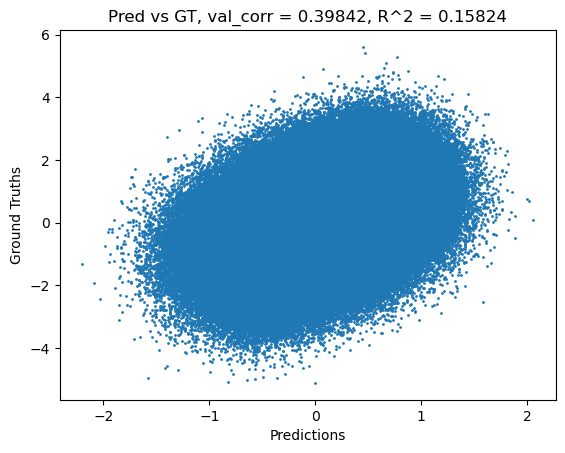

Prediction correlation: 0.398426178969267
R squared: 0.1582466138595835
MSE: 1.0258238315582275
Unflattened R^2 0.14053339071971688


In [5]:
model_checkpoint_path = "../../output/Baselines/AwC_sim_42.ckpt"

trained_model = models.Attention_With_Constraint_sim.load_from_checkpoint(model_checkpoint_path)
trained_model.eval()

trainer = pl.Trainer(
    devices=[0],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)
val_results = trainer.predict(trained_model, dataloaders=[validloader])

predictions = []
ground_truths = []
for i in range(len(val_results)):
    x_hat = val_results[i][0]    # batch_size * (neuron_num*time)
    x = val_results[i][1]

    predictions.append(x_hat)
    ground_truths.append(x)

predictions = torch.cat(predictions, dim=0).cpu().numpy()  # N * neuron_num * window_size
ground_truths = torch.cat(ground_truths, dim=0).cpu().numpy()  # N * neuron_num * window_size
pred_corr = stats.pearsonr(predictions.flatten(), ground_truths.flatten())[0]
R_squared = r2_score(ground_truths.flatten(), predictions.flatten())

plt.scatter(predictions.flatten(), ground_truths.flatten(), s=1)
plt.title("Pred vs GT, val_corr = " + str(pred_corr)[:7] + ", R^2 = " + str(R_squared)[:7])
plt.xlabel("Predictions")
plt.ylabel("Ground Truths")
plt.show()

print(f"Prediction correlation: {pred_corr}")
print(f"R squared: {R_squared}")
print('MSE:', F.mse_loss(torch.tensor(predictions), torch.tensor(ground_truths)).item())
print('Unflattened R^2', r2_score(ground_truths.reshape(-1, neuron_num), predictions.reshape(-1, neuron_num), multioutput='variance_weighted'))

### Attention

You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/homes/gws/wz86/miniconda3/envs/func2graph/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 744/744 [00:05<00:00, 148.55it/s]


PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  13024          	|  18.063         	

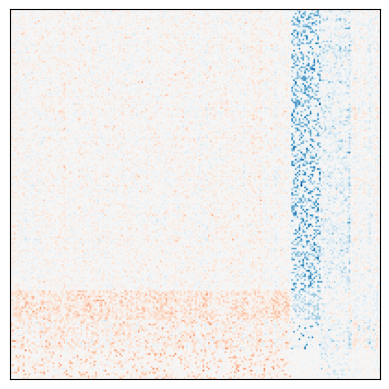

In [5]:
train_results = trainer.predict(trained_model, dataloaders=[trainloader])

attentions = []
for i in range(len(train_results)):
    x_hat = train_results[i][0]    # batch_size * (neuron_num*time)
    x = train_results[i][1]
    attention = train_results[i][2]
    
    attention = attention.view(-1, neuron_num, neuron_num)
    attentions.append(attention)

attentions = torch.cat(attentions, dim=0).cpu().numpy()    # N * neuron_num * neuron_num
avg_attention = np.mean(attentions, axis=0)   # neuron_num * neuron_num
W = avg_attention

transformed_W = tools.linear_transform(W, weight_matrix)
plt.imshow(transformed_W, cmap='RdBu_r', vmin=vmin_NN, vmax=vmax_NN)
plt.xticks([])
plt.yticks([])
plt.show()

In [19]:
KK_GT = np.load('../../data/Mouse_Local_Connectivity/GT_strength_connectivity.npy')
max_abs = np.max(np.abs(KK_GT))
vmin_KK = -max_abs
vmax_KK = max_abs

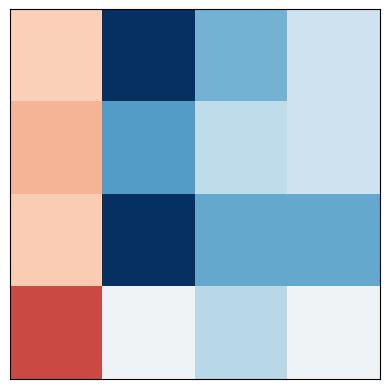

In [22]:
cell_type_id2cell_type = {0:'EC', 1:'Pvalb', 2:'Sst', 3:'Vip'}
KK_strength = tools.calculate_cell_type_level_connectivity_matrix_remove_no_connection(
    connectivity_matrix_new=W,
    connectivity_matrix_GT=weight_matrix, 
    cell_type_id2cell_type=cell_type_id2cell_type,
    cell_type_count=cell_type_count
)

transformed_KK_strength = tools.linear_transform(KK_strength, KK_GT)

plt.imshow(transformed_KK_strength, cmap='RdBu_r', vmin=vmin_KK, vmax=vmax_KK)
plt.xticks([])
plt.yticks([])
plt.show()

### Temporal Assotication

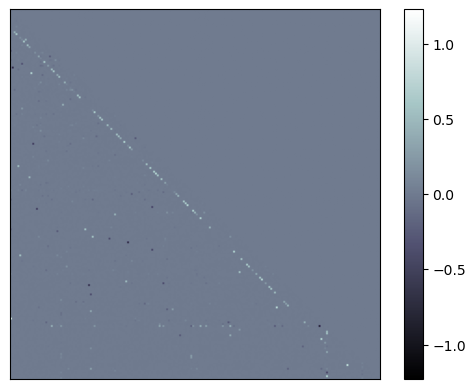

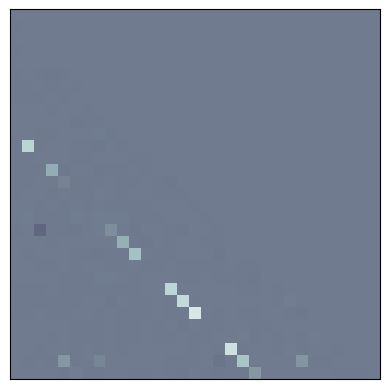

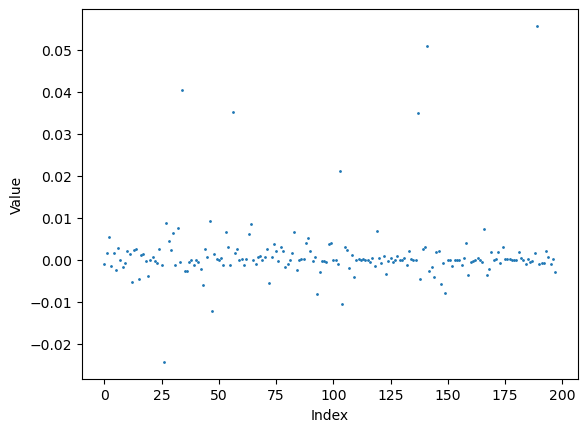

In [33]:
TT = trained_model.attentionlayers[0][0].W_Q_W_KT.weight.cpu().detach().numpy()

tau = 1

TT = TT.T  #################### this is important !!!! because torch.Linear.weight is (output_dim, input_dim)

abs_max = np.max(np.abs(TT))
plt.imshow(TT, cmap='bone', vmin=-abs_max, vmax=abs_max)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

plt.imshow(TT[80:111, 80:111], cmap='bone', vmin=-1, vmax=1)
plt.xticks([])
plt.yticks([])
plt.show()

# print diagnal
l = list()
for i in range(tau, TT.shape[0]):
    l.append(TT[i][i-tau])  #########################

plt.scatter(range(len(l)), l, s=1)
plt.xlabel("Index")
plt.ylabel("Value")
plt.show()

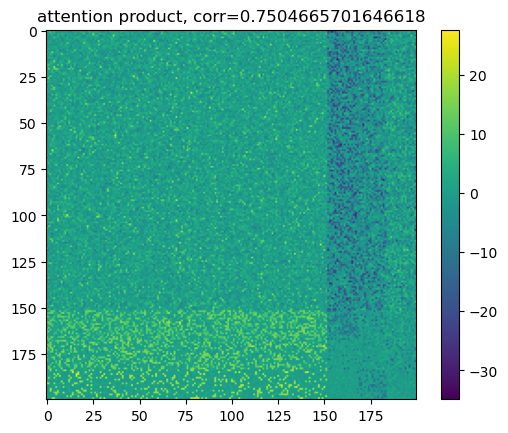

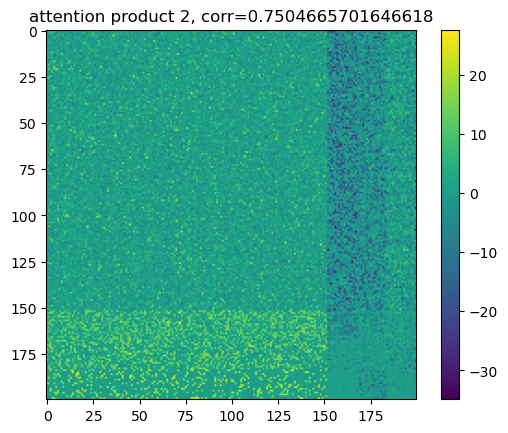

In [34]:
layer_norm = model_checkpoint.layer_norm.cpu()
E = model_checkpoint.embedding_table.weight.cpu().detach().numpy()

layer = model_checkpoint.attentionlayers[0][0].W_Q_W_KT.cpu()

product = []
product_2 = []
for i in range(23808-window_size+1):
    one_sample = np.array(result[:, i:i+window_size-1]).astype(np.float32)
    product.append((layer_norm(torch.from_numpy(one_sample+E)).detach().numpy() @ (TT) @ layer_norm(torch.from_numpy(one_sample+E)).T.detach().numpy()).reshape(1, 200, 200))
    x_ = layer(layer_norm(torch.from_numpy(one_sample+E))).detach().numpy()
    product_2.append((x_ @ layer_norm(torch.from_numpy(one_sample+E)).T.detach().numpy()).reshape(1, 200, 200))

product = np.concatenate(product, axis=0)
product = np.mean(product, axis=0)
product_2 = np.concatenate(product_2, axis=0)
product_2 = np.mean(product_2, axis=0)

plt.imshow(product)
plt.colorbar()
plt.title("attention product, corr=" + str(stats.pearsonr(weight_matrix.flatten(), product.flatten())[0]))
plt.show()

plt.imshow(product_2)
plt.colorbar()
plt.title("attention product 2, corr=" + str(stats.pearsonr(weight_matrix.flatten(), product_2.flatten())[0]))
plt.show()

torch.Size([200, 199])
[[-8.4089510e-02  4.1393223e-01 -1.7624998e-01 ...  7.5340736e-01
   9.3744254e-01  2.8873822e-01]
 [ 8.1661892e-01 -4.7266182e-01 -7.0141196e-01 ...  6.0716510e-01
  -1.4842952e+00  1.8677945e+00]
 [-1.5041420e+00  6.2263906e-01  3.6559007e-01 ... -3.7897006e-01
  -1.4965279e+00  1.3625708e-01]
 ...
 [ 5.2739263e-01  1.0485491e-01 -2.2147065e-01 ... -1.3507943e-01
   1.2003534e-01 -3.3865198e-01]
 [ 6.5067184e-01  1.4871073e+00 -7.9921454e-01 ...  1.0592798e+00
  -1.0591832e-01  1.0612298e+00]
 [-6.9809626e-03  2.7363578e-02 -4.1425354e-03 ... -8.1356196e-03
  -1.0625181e-03 -1.9773511e-02]]


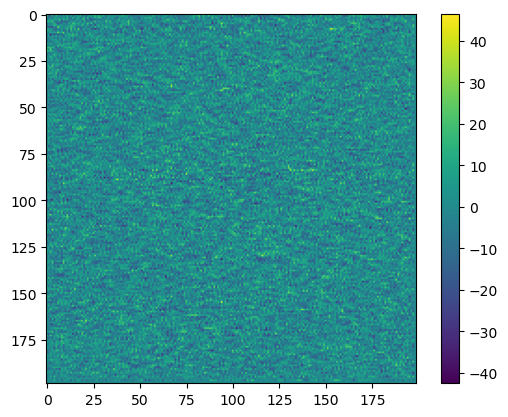

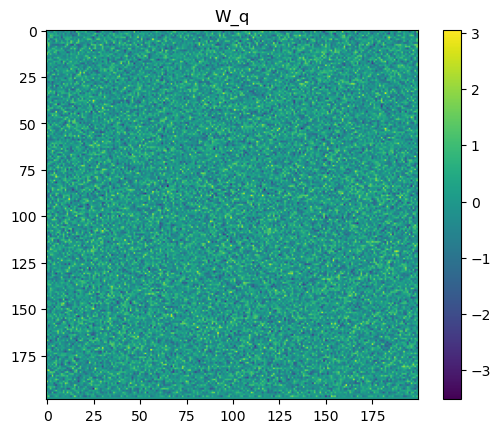

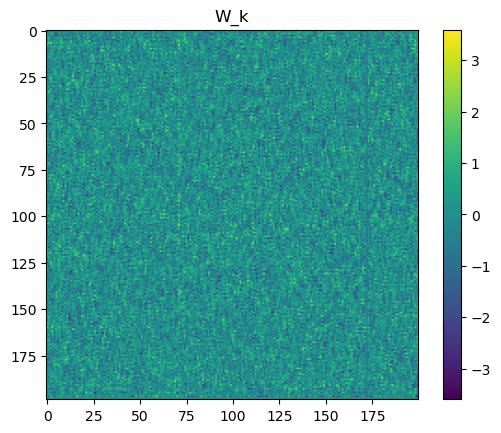

In [6]:
print(model_checkpoint.attentionlayers[0][0].to_q.weight.cpu().shape)
W_q = model_checkpoint.attentionlayers[0][0].to_q.weight.cpu().detach().numpy()
W_q = W_q.T
print(W_q)
W_k = model_checkpoint.attentionlayers[0][0].to_k.weight.cpu().detach().numpy()
W_k = W_k.T
E = model_checkpoint.embedding_table.weight.cpu().detach().numpy()

product = W_q @ W_k.T
product = product
plt.imshow(product)
# draw a diagonal line
# plt.plot([0, 199], [0, 199], color='red', linewidth=0.2)
plt.colorbar()
plt.show()

plt.imshow(W_q)
plt.colorbar()
plt.title("W_q")
plt.show()

plt.imshow(W_k)
plt.colorbar()
plt.title("W_k")
plt.show()

# compute the correlation between the weight matrix and the product of W_q and W_k
weight_matrix = simulator.W_ij
#stats.pearsonr(weight_matrix.detach().numpy().flatten(), product.flatten())

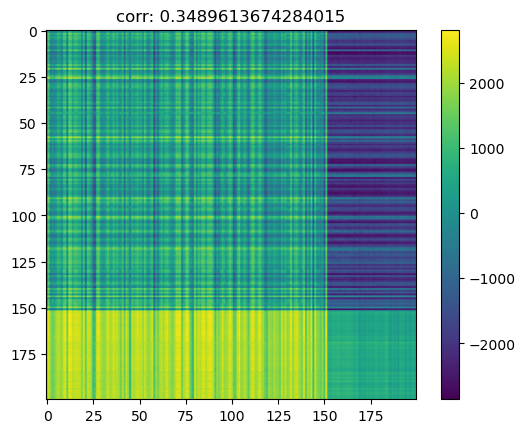

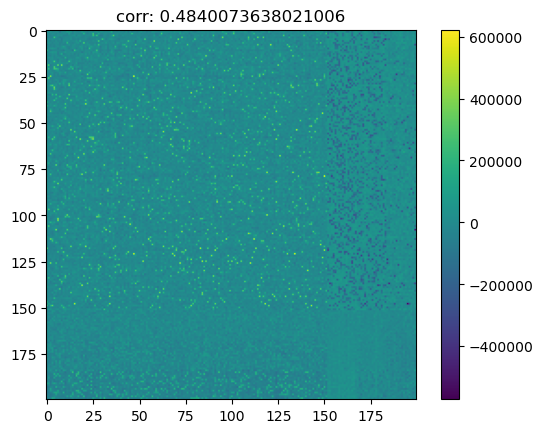

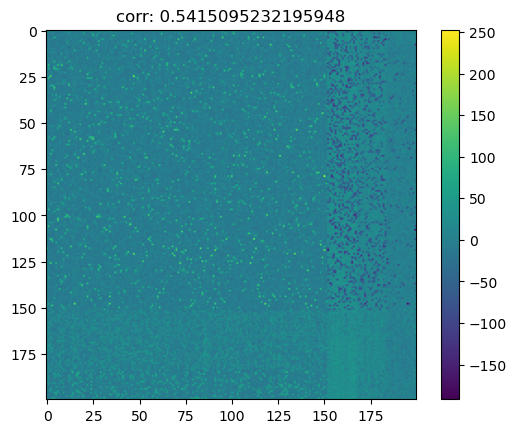

In [7]:
layer_norm = model_checkpoint.layer_norm.cpu()
rel_content_bias = model_checkpoint.attentionlayers[0][0].rel_content_bias.cpu().detach().numpy()
q_scale = dim_key ** -0.5

product_2 = []
product_3 = []
product_4 = []
for i in range(23808-window_size+1):
    one_sample = np.array(result[:, i:i+window_size-1])
    product_2.append(((one_sample) @ W_q @ W_k.T @ (one_sample.T)).reshape(1, 200, 200))
    product_3.append(((one_sample+E) @ W_q @ W_k.T @ (one_sample.T+E.T)).reshape(1, 200, 200))
    # product_4.append(((layer_norm(torch.from_numpy(one_sample+E)).detach().numpy() @ W_q * q_scale + rel_content_bias) @ W_k.T @ layer_norm(torch.from_numpy(one_sample+E)).T.detach().numpy()).reshape(1, 200, 200))
    product_4.append((layer_norm(torch.from_numpy(one_sample+E)).detach().numpy() @ W_q * q_scale @ W_k.T @ layer_norm(torch.from_numpy(one_sample+E)).T.detach().numpy()).reshape(1, 200, 200))

product_2 = np.concatenate(product_2, axis=0)
product_3 = np.concatenate(product_3, axis=0)
product_4 = np.concatenate(product_4, axis=0)
# average over all the samples
product_2 = np.mean(product_2, axis=0)
product_3 = np.mean(product_3, axis=0)
product_4 = np.mean(product_4, axis=0)

corr_2 = np.corrcoef(weight_matrix.detach().numpy().flatten(), product_2.flatten())[0,1]
corr_3 = np.corrcoef(weight_matrix.detach().numpy().flatten(), product_3.flatten())[0,1]
corr_4 = np.corrcoef(weight_matrix.detach().numpy().flatten(), product_4.flatten())[0,1]

plt.imshow(product_2)
plt.colorbar()
plt.title("corr: " + str(corr_2))
plt.show()

plt.imshow(product_3)
plt.colorbar()
plt.title("corr: " + str(corr_3))
plt.show()

plt.imshow(product_4)
plt.colorbar()
plt.title("corr: " + str(corr_4))
plt.show()

### Explore Attention change across different samples and time

torch.Size([200, 30000])
val_data.shape:  torch.Size([5801, 200, 200])
tensor([[-0.6457, -0.2359,  2.4121,  ..., -0.7366, -1.3893,  0.6129],
        [ 0.4704,  0.3074,  0.4413,  ...,  0.7819, -1.4319, -0.0138],
        [-1.0159,  0.3407,  0.1530,  ..., -0.2355, -0.3548, -0.4085],
        ...,
        [-1.1923, -0.1005,  0.3699,  ..., -1.0881, -0.4430, -2.5251],
        [-1.1178, -0.5067,  1.3893,  ..., -0.8344, -0.2150, -0.8620],
        [ 2.1243,  1.0031, -1.7388,  ..., -0.3255, -0.7487, -1.7132]])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /homes/gws/wz86/func2graph/notebook/check_evaluation/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Predicting DataLoader 0:   0%|          | 0/744 [00:00<?, ?it/s]1
3
Predicting DataLoader 0:   0%|          | 1/744 [00:01<13:43,  1.11s/it]1
3
Predicting DataLoader 0:   0%|          | 2/744 [00:01<06:53,  1.79it/s]1
3
Predicting DataLoader 0:   0%|          | 3/744 [00:01<04:36,  2.68it/s]1
3
Predicting DataLoader 0:   1%|          | 4/744 [00:01<03:28,  3.55it/s]1
3
Predicting DataLoader 0:   1%|          | 5/744 [00:01<02:47,  4.41it/s]1
3
Predicting DataLoader 0:   1%|          | 6/744 [00:01<02:20,  5.27it/s]1
3
Predicting DataLoader 0:   1%|          | 7/744 [00:01<02:00,  6.11it/s]1
3
Predicting DataLoader 0:   1%|          | 8/744 [00:01<01:46,  6.94it/s]1
3
Predicting DataLoader 0:   1%|          | 9/744 [00:01<01:34,  7.77it/s]1
3
Predicting DataLoader 0:   1%|▏         | 10/744 [00:01<01:25,  8.59it/s]1
3
Predicting DataLoader 0:   1%|▏         | 11/744 [00:01<01:18,  9.40it/s]1
3
Predicting DataLoader 0:   2%|▏         | 12/744 [00:01<01:11, 10.20it/s]1
3
Predicting DataLo

PREDICT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                      	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                       	|  -              	|  10446          	|  12.428         	

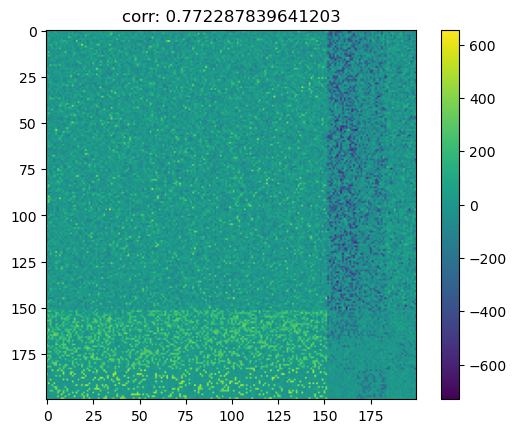

In [3]:
neuron_num = 200   #####################
tau = 2   #####################
weight_scale = 0.1
init_scale = 0.1
total_time = 30000

data_random_seed=42 ######################

weight_type="cell_type"

data_result = data.generate_simulation_data(
    neuron_num=neuron_num,
    tau=tau,
    weight_scale=weight_scale,
    init_scale=init_scale,
    total_time=total_time,
    data_random_seed=data_random_seed,
    weight_type=weight_type,
    window_size=200,
    task_type='prediction',
    predict_window_size=1,
    batch_size=32,
    data_type='wuwei',
)
trainloader, validloader, weight_matrix, cell_type_ids, cell_type2id, cell_type_count = data_result

trainer = pl.Trainer(
    devices=[1],
    accelerator="gpu",
    benchmark=False,
    profiler="simple",
)

model = models.Attention_With_Constraint_sim.load_from_checkpoint("../../output/3_27_AwC/AwC_sim_2.0_1_wuwei_200_200_42_42_1_none_lookup_table_none_1_0.0_0.001_cycle_mse_0.0_0.1_0.0/epoch=997-step=742512.ckpt")
train_results = trainer.predict(model, dataloaders=[trainloader])

predictions = []
ground_truths = []
attentions = []
for i in range(len(train_results)):
    x_hat = train_results[i][0]    # batch_size * (neuron_num*time)
    x = train_results[i][1]
    attention = train_results[i][2]
    neuron_embedding = train_results[i][3]
    
    attention = attention.view(-1, neuron_num, neuron_num)

    predictions.append(x_hat)
    ground_truths.append(x)
    attentions.append(attention)

predictions = torch.cat(predictions, dim=0).cpu().numpy()  # N * neuron_num * window_size
ground_truths = torch.cat(ground_truths, dim=0).cpu().numpy()  # N * neuron_num * window_size
attentions = torch.cat(attentions, dim=0).cpu().numpy()    # N * neuron_num * neuron_num

# # get average attention across 
avg_attention = np.mean(attentions, axis=0)   # neuron_num * neuron_num
W = avg_attention

plt.imshow(W)
plt.colorbar()
plt.title("corr: " + str(np.corrcoef(weight_matrix.detach().numpy().flatten(), W.flatten())[0,1]))
plt.show()

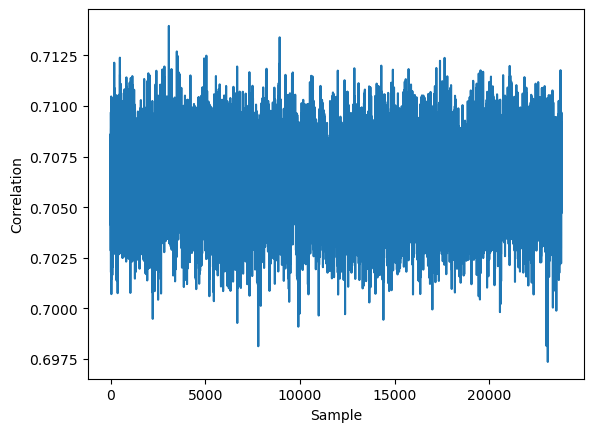

In [15]:
# compute corr for each attention
corrs = []
for i in range(attentions.shape[0]):
    W = attentions[i, :, :]
    corrs.append(np.corrcoef(weight_matrix.detach().numpy().flatten(), W.flatten())[0,1])

plt.plot(corrs)
plt.xlabel("Sample")
plt.ylabel("Correlation")
plt.show()